# Notebook 1: Trader Data Preparation & Feature Engineering

**Objective:** Prepare historical trader data for behavioral analysis and engineer meaningful trader-level features.

**Author:** Hanzala Saify  
**Date:** January 2026

---

# SECTION 1 — Data Loading & Validation

## 1.1 Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1.2 Load Trader Data

In [2]:
# Load the historical trader data
df = pd.read_csv('csv_files/historical_data.csv')

# Basic info
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn Names:\n{df.columns.tolist()}")

Dataset Shape: 211,224 rows × 16 columns

Column Names:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


## 1.3 Schema & Data Types

In [3]:
# Display schema and data types
print("=" * 60)
print("DATA SCHEMA & TYPES")
print("=" * 60)
print(df.dtypes)
print("\n" + "=" * 60)
print("SAMPLE DATA (First 5 rows)")
print("=" * 60)
df.head()

DATA SCHEMA & TYPES
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

SAMPLE DATA (First 5 rows)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.8700,7872.1600,BUY,02-12-2024 22:50,0.0000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.3454,895000000000000.0000,1730000000000.0000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.0000,127.6800,BUY,02-12-2024 22:50,986.5246,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0056,443000000000000.0000,1730000000000.0000
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.0900,1150.6300,BUY,02-12-2024 22:50,1002.5190,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0504,660000000000000.0000,1730000000000.0000
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.9800,1142.0400,BUY,02-12-2024 22:50,1146.5586,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0500,1080000000000000.0000,1730000000000.0000
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.7300,69.7500,BUY,02-12-2024 22:50,1289.4885,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0031,1050000000000000.0000,1730000000000.0000


## 1.4 Missing Value Summary

In [4]:
# Missing value analysis
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum().values / len(df) * 100).round(2),
    'Dtype': df.dtypes.values
})
missing_summary = missing_summary.sort_values('Missing %', ascending=False)

print("=" * 60)
print("MISSING VALUE SUMMARY")
print("=" * 60)
print(missing_summary.to_string(index=False))
print(f"\nTotal rows: {len(df):,}")
print(f"Complete rows: {df.dropna().shape[0]:,}")

MISSING VALUE SUMMARY
          Column  Missing Count  Missing %   Dtype
         Account              0     0.0000  object
            Coin              0     0.0000  object
 Execution Price              0     0.0000 float64
     Size Tokens              0     0.0000 float64
        Size USD              0     0.0000 float64
            Side              0     0.0000  object
   Timestamp IST              0     0.0000  object
  Start Position              0     0.0000 float64
       Direction              0     0.0000  object
      Closed PnL              0     0.0000 float64
Transaction Hash              0     0.0000  object
        Order ID              0     0.0000   int64
         Crossed              0     0.0000    bool
             Fee              0     0.0000 float64
        Trade ID              0     0.0000 float64
       Timestamp              0     0.0000 float64

Total rows: 211,224
Complete rows: 211,224


## 1.5 Understanding Data Granularity

### Trade-Level vs Position-Level Data

This dataset is at the **execution/trade level**, not position level. Key observations:

| Aspect | Observation |
|--------|-------------|
| **Granularity** | Each row represents a single **trade execution** (fill) |
| **Order Splitting** | A single order may result in multiple executions at different prices (partial fills) |
| **Position Tracking** | `Start Position` column tracks cumulative position before each execution |
| **PnL Attribution** | `Closed PnL` is only populated when a position is reduced/closed |

**Trading Context:**
- **Execution-level granularity** is critical for analyzing slippage, market impact, and execution quality
- Multiple executions with the same `Order ID` indicate a large order filled across multiple price levels
- `Closed PnL = 0` doesn't mean no trade; it means the trade opened/added to a position rather than closing one
- The `Start Position` column allows us to reconstruct the trader's position trajectory

**Implications for Analysis:**
1. For PnL analysis, we must filter to rows where `Closed PnL != 0`
2. For volume/activity analysis, we use all execution rows
3. Aggregation to daily level must account for partial fills within the same order

---

# SECTION 2 — Data Cleaning

This section focuses on transforming raw trade data into analysis-ready format. Each cleaning step is explained from a trading perspective.

## 2.1 Timestamp Conversion (IST → UTC)

**Why this matters:**
- Original timestamps are in IST (Indian Standard Time, UTC+5:30)
- For consistent analysis and potential integration with global market data, UTC is the standard
- Timezone-aware datetimes prevent silent errors in time-based aggregations

In [5]:
# Convert Timestamp IST to timezone-aware UTC datetime
# IST is UTC+5:30

# Parse the timestamp string (format: DD-MM-YYYY HH:MM)
df['timestamp_ist'] = pd.to_datetime(df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Localize to IST and convert to UTC
df['timestamp_utc'] = (df['timestamp_ist']
                        .dt.tz_localize('Asia/Kolkata')
                        .dt.tz_convert('UTC'))

# Create trade_date column (UTC date only)
df['trade_date'] = df['timestamp_utc'].dt.date

# Verify conversion
print("Timestamp Conversion Sample:")
print(df[['Timestamp IST', 'timestamp_ist', 'timestamp_utc', 'trade_date']].head(3))
print(f"\nDate range: {df['trade_date'].min()} to {df['trade_date'].max()}")

Timestamp Conversion Sample:
      Timestamp IST       timestamp_ist             timestamp_utc  trade_date
0  02-12-2024 22:50 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
1  02-12-2024 22:50 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
2  02-12-2024 22:50 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02

Date range: 2023-04-30 to 2025-05-01


## 2.2 Normalize Side & Direction Columns

**Trading Context:**
- `Side` indicates the order type (BUY/SELL) - what the trader executed
- `Direction` indicates the position direction after the trade (Buy = Long, Sell = Short)
- Standardizing these to lowercase ensures consistent filtering and grouping
- This is critical for calculating signed positions and directional bias metrics

In [6]:
# Normalize Side and Direction columns
print("Before normalization:")
print(f"  Side values: {df['Side'].unique()}")
print(f"  Direction values: {df['Direction'].unique()}")

# Convert to lowercase and strip whitespace
df['side'] = df['Side'].str.strip().str.lower()
df['direction'] = df['Direction'].str.strip().str.lower()

print("\nAfter normalization:")
print(f"  side values: {df['side'].unique()}")
print(f"  direction values: {df['direction'].unique()}")

# Distribution
print("\n Side Distribution:")
print(df['side'].value_counts())
print("\nDirection Distribution:")
print(df['direction'].value_counts())

Before normalization:
  Side values: ['BUY' 'SELL']
  Direction values: ['Buy' 'Sell' 'Open Long' 'Close Long' 'Spot Dust Conversion' 'Open Short'
 'Close Short' 'Long > Short' 'Short > Long' 'Auto-Deleveraging'
 'Liquidated Isolated Short' 'Settlement']

After normalization:
  side values: ['buy' 'sell']
  direction values: ['buy' 'sell' 'open long' 'close long' 'spot dust conversion' 'open short'
 'close short' 'long > short' 'short > long' 'auto-deleveraging'
 'liquidated isolated short' 'settlement']

 Side Distribution:
side
sell    108528
buy     102696
Name: count, dtype: int64

Direction Distribution:
direction
open long                    49895
close long                   48678
open short                   39741
close short                  36013
sell                         19902
buy                          16716
spot dust conversion           142
short > long                    70
long > short                    57
auto-deleveraging                8
liquidated isolated sho

## 2.3 Handle Zero/Null Closed PnL Rows

**Trading Perspective:**
- `Closed PnL = 0` does **NOT** mean the trade was unprofitable
- It means the trade **opened or added to a position** rather than closing one
- Closing trades are the only ones that realize profit/loss
- We need to:
  1. Keep ALL execution rows for volume/activity analysis
  2. Create `is_closed_trade` flag to identify trades that closed positions
  3. Use this flag to filter when analyzing realized PnL

In [7]:
# Analyze Closed PnL distribution
print("Closed PnL Analysis:")
print(f"  Total rows: {len(df):,}")
print(f"  Rows with Closed PnL = 0: {(df['Closed PnL'] == 0).sum():,}")
print(f"  Rows with Closed PnL != 0: {(df['Closed PnL'] != 0).sum():,}")
print(f"  Rows with null Closed PnL: {df['Closed PnL'].isna().sum():,}")

# Create is_closed_trade flag
# A trade is considered a "closing trade" if it resulted in realized PnL
df['is_closed_trade'] = (df['Closed PnL'] != 0) & (df['Closed PnL'].notna())

print(f"\nis_closed_trade flag distribution:")
print(df['is_closed_trade'].value_counts())
print(f"\nPercentage of closing trades: {df['is_closed_trade'].mean()*100:.2f}%")

Closed PnL Analysis:
  Total rows: 211,224
  Rows with Closed PnL = 0: 106,816
  Rows with Closed PnL != 0: 104,408
  Rows with null Closed PnL: 0

is_closed_trade flag distribution:
is_closed_trade
False    106816
True     104408
Name: count, dtype: int64

Percentage of closing trades: 49.43%


## 2.4 Remove Extreme Fee Outliers

**Trading Perspective:**
- Trading fees are typically a small percentage of notional value (0.01% - 0.1%)
- Extreme fee outliers could indicate:
  - Data entry errors
  - Unusual market conditions (extreme slippage)
  - Test/erroneous transactions
- We remove the 99.9th percentile to maintain data integrity
- This conservative threshold preserves legitimate high-fee trades while removing clear anomalies

In [8]:
# Analyze fee distribution before removal
print("Fee Distribution (Before Outlier Removal):")
print(df['Fee'].describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]))

# Calculate 99.9th percentile threshold
fee_threshold = df['Fee'].quantile(0.999)
print(f"\n99.9th percentile threshold: {fee_threshold:.4f}")

# Count outliers
outliers_count = (df['Fee'] > fee_threshold).sum()
print(f"Number of rows to remove: {outliers_count:,} ({outliers_count/len(df)*100:.3f}%)")

# Remove extreme fee outliers
df_before = len(df)
df = df[df['Fee'] <= fee_threshold].copy()
df_after = len(df)

print(f"\nRows removed: {df_before - df_after:,}")
print(f"Remaining rows: {df_after:,}")

Fee Distribution (Before Outlier Removal):
count   211224.0000
mean         1.1640
std          6.7589
min         -1.1757
50%          0.0896
90%          1.7216
95%          4.4994
99%         20.9997
99.9%       75.0000
max        837.4716
Name: Fee, dtype: float64

99.9th percentile threshold: 75.0000
Number of rows to remove: 212 (0.100%)

Rows removed: 212
Remaining rows: 211,012


## 2.5 Ensure Correct Numeric Types

**Why this matters:**
- Numeric fields may be read as strings due to formatting issues
- Proper types are essential for mathematical operations and aggregations
- Float precision matters for financial calculations

In [9]:
# Define numeric columns and their expected types
numeric_columns = {
    'Execution Price': 'float64',
    'Size Tokens': 'float64',
    'Size USD': 'float64',
    'Start Position': 'float64',
    'Closed PnL': 'float64',
    'Fee': 'float64'
}

# Convert and validate numeric types
for col, dtype in numeric_columns.items():
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Verify types
print("Numeric Column Types (After Conversion):")
for col in numeric_columns.keys():
    print(f"  {col}: {df[col].dtype}")

# Check for any conversion failures (NaN introduced)
print("\nNull values after numeric conversion:")
for col in numeric_columns.keys():
    null_count = df[col].isna().sum()
    if null_count > 0:
        print(f"  {col}: {null_count:,} nulls")

Numeric Column Types (After Conversion):
  Execution Price: float64
  Size Tokens: float64
  Size USD: float64
  Start Position: float64
  Closed PnL: float64
  Fee: float64

Null values after numeric conversion:


## 2.6 Data Cleaning Summary

A summary of all cleaning operations performed:

In [10]:
# Cleaning summary
print("=" * 60)
print("DATA CLEANING SUMMARY")
print("=" * 60)
print(f"""
✓ Timestamp Conversion:
  - Converted 'Timestamp IST' to timezone-aware UTC datetime
  - Created 'trade_date' column for daily aggregations

✓ Column Normalization:
  - Standardized 'side' and 'direction' to lowercase

✓ Closed PnL Handling:
  - Created 'is_closed_trade' flag to identify position-closing trades
  - Preserved all execution rows for complete volume analysis

✓ Fee Outlier Removal:
  - Removed trades above 99.9th percentile fee threshold

✓ Type Conversion:
  - Ensured all numeric fields are properly typed as float64

Final Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns
""")

# Display final schema
print("\nFinal Column List:")
print(df.columns.tolist())

DATA CLEANING SUMMARY

✓ Timestamp Conversion:
  - Converted 'Timestamp IST' to timezone-aware UTC datetime
  - Created 'trade_date' column for daily aggregations

✓ Column Normalization:
  - Standardized 'side' and 'direction' to lowercase

✓ Closed PnL Handling:
  - Created 'is_closed_trade' flag to identify position-closing trades
  - Preserved all execution rows for complete volume analysis

✓ Fee Outlier Removal:
  - Removed trades above 99.9th percentile fee threshold

✓ Type Conversion:
  - Ensured all numeric fields are properly typed as float64

Final Dataset Shape: 211,012 rows × 22 columns


Final Column List:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'timestamp_ist', 'timestamp_utc', 'trade_date', 'side', 'direction', 'is_closed_trade']


---

# SECTION 3 — Feature Engineering

This section creates meaningful features at both trade-level and daily trader aggregation level for behavioral analysis.

## 3.1 Trade-Level Features

Creating features that describe individual trade characteristics:

| Feature | Description | Use Case |
|---------|-------------|----------|
| `trade_notional` | USD value of the trade (Size USD) | Volume analysis, position sizing |
| `signed_size` | Directional size (+ve for buy, -ve for sell) | Net exposure calculation |
| `fee_pct` | Fee as percentage of notional | Cost analysis |
| `is_win` | Whether the trade was profitable (for closing trades) | Win rate calculation |

In [11]:
# =============================================================================
# TRADE-LEVEL FEATURE ENGINEERING
# =============================================================================

# 1. Trade Notional (already exists as Size USD, but rename for clarity)
df['trade_notional'] = df['Size USD']

# 2. Signed Size: Positive for buys, negative for sells
# This allows us to calculate net exposure
df['signed_size'] = np.where(df['side'] == 'buy', 
                              df['Size Tokens'], 
                              -df['Size Tokens'])

# 3. Fee Percentage: Fee as a percentage of trade notional
# Avoid division by zero
df['fee_pct'] = np.where(df['trade_notional'] > 0,
                          (df['Fee'] / df['trade_notional']) * 100,
                          0)

# 4. Is Win: For closing trades, was the PnL positive?
# Only meaningful for trades where is_closed_trade = True
df['is_win'] = np.where(df['is_closed_trade'], 
                         df['Closed PnL'] > 0, 
                         np.nan)

# Display sample of new features
print("Trade-Level Features Sample:")
print(df[['side', 'Size Tokens', 'signed_size', 'trade_notional', 
          'Fee', 'fee_pct', 'Closed PnL', 'is_closed_trade', 'is_win']].head(10))

Trade-Level Features Sample:
  side  Size Tokens  signed_size  trade_notional    Fee  fee_pct  Closed PnL  \
0  buy     986.8700     986.8700       7872.1600 0.3454   0.0044      0.0000   
1  buy      16.0000      16.0000        127.6800 0.0056   0.0044      0.0000   
2  buy     144.0900     144.0900       1150.6300 0.0504   0.0044      0.0000   
3  buy     142.9800     142.9800       1142.0400 0.0500   0.0044      0.0000   
4  buy       8.7300       8.7300         69.7500 0.0031   0.0044      0.0000   
5  buy       1.4100       1.4100         11.2700 0.0005   0.0044      0.0000   
6  buy     144.0900     144.0900       1151.7700 0.0504   0.0044      0.0000   
7  buy      34.0000      34.0000        272.0000 0.0119   0.0044      0.0000   
8  buy      46.0000      46.0000        368.0000 0.0161   0.0044      0.0000   
9  buy      12.5000      12.5000        100.0000 0.0044   0.0044      0.0000   

   is_closed_trade  is_win  
0            False     NaN  
1            False     NaN  
2  

In [13]:
# Feature statistics
print("\nTrade-Level Feature Statistics:")
print("=" * 50)
print(f"\ntrade_notional (USD):")
print(df['trade_notional'].describe())

print(f"\nsigned_size (Tokens):")
print(df['signed_size'].describe())

print(f"\nfee_pct (%):")
print(df['fee_pct'].describe())

print(f"\nis_win (for closing trades only):")
closing_trades = df[df['is_closed_trade'] == True]
print(f"  Total closing trades: {len(closing_trades):,}")
print(f"  Winning trades: {closing_trades['is_win'].sum():,.0f}")
print(f"  Losing trades: {(closing_trades['is_win'] == False).sum():,.0f}")
print(f"  Win rate: {closing_trades['is_win'].mean()*100:.2f}%")


Trade-Level Feature Statistics:

trade_notional (USD):
count    211012.0000
mean       5087.2344
std       28367.8361
min           0.0000
25%         193.6300
50%         596.2500
75%        2052.8225
max     3921430.7200
Name: trade_notional, dtype: float64

signed_size (Tokens):
count      211012.0000
mean           -6.5590
std        104409.5156
min     -15822438.0000
25%           -34.7900
50%            -0.0050
75%            29.4000
max      11500000.0000
Name: signed_size, dtype: float64

fee_pct (%):
count   211012.0000
mean         0.0309
std          0.6176
min         -0.0020
25%          0.0096
50%          0.0250
75%          0.0350
max        119.2853
Name: fee_pct, dtype: float64

is_win (for closing trades only):
  Total closing trades: 104,297
  Winning trades: 86,778
  Losing trades: 17,519
  Win rate: 83.20%


## 3.2 Daily Trader Aggregation

Aggregating trade-level data to daily metrics per trader. This enables:
- Time-series analysis of trader behavior
- Comparison across traders on consistent timeframes
- Detection of behavioral patterns (overtrading, tilt, etc.)

| Metric | Description | Behavioral Insight |
|--------|-------------|-------------------|
| `daily_pnl` | Sum of realized PnL for the day | Profitability trend |
| `daily_volume` | Total traded volume (USD) | Activity level |
| `avg_leverage` | Average position size relative to price | Risk appetite |
| `num_trades` | Count of executions | Trading frequency |
| `win_rate` | % of profitable closing trades | Skill/edge indicator |
| `pnl_volatility` | Std dev of trade-level PnL | Risk consistency |

In [14]:
# =============================================================================
# DAILY TRADER AGGREGATION
# =============================================================================

# Group by Account (trader) and trade_date
daily_metrics = df.groupby(['Account', 'trade_date']).agg(
    # Daily PnL: Sum of closed PnL (only from closing trades)
    daily_pnl=('Closed PnL', 'sum'),
    
    # Daily Volume: Total traded notional
    daily_volume=('trade_notional', 'sum'),
    
    # Average Leverage: Mean of (Size USD / Execution Price) as proxy
    # Note: True leverage requires account balance data
    avg_trade_size=('trade_notional', 'mean'),
    
    # Number of trades (executions)
    num_trades=('Trade ID', 'count'),
    
    # Total fees
    daily_fees=('Fee', 'sum'),
    
    # Win count (for closing trades)
    win_count=('is_win', lambda x: x.sum() if x.notna().any() else 0),
    
    # Total closing trades
    closing_trade_count=('is_closed_trade', 'sum'),
    
    # PnL volatility (std of individual trade PnLs)
    pnl_volatility=('Closed PnL', lambda x: x[x != 0].std() if (x != 0).any() else 0),
    
    # Directional bias
    net_signed_size=('signed_size', 'sum'),
    buy_volume=('trade_notional', lambda x: x[df.loc[x.index, 'side'] == 'buy'].sum()),
    
).reset_index()

# Calculate derived metrics
daily_metrics['win_rate'] = np.where(
    daily_metrics['closing_trade_count'] > 0,
    daily_metrics['win_count'] / daily_metrics['closing_trade_count'] * 100,
    np.nan
)

# Fee percentage of daily volume
daily_metrics['fee_pct_of_volume'] = np.where(
    daily_metrics['daily_volume'] > 0,
    (daily_metrics['daily_fees'] / daily_metrics['daily_volume']) * 100,
    0
)

print(f"Daily Metrics Shape: {daily_metrics.shape}")
print(f"Unique Traders: {daily_metrics['Account'].nunique():,}")
print(f"Date Range: {daily_metrics['trade_date'].min()} to {daily_metrics['trade_date'].max()}")
daily_metrics.head()

Daily Metrics Shape: (2343, 14)
Unique Traders: 32
Date Range: 2023-04-30 to 2025-05-01


,Account,trade_date,daily_pnl,daily_volume,avg_trade_size,num_trades,daily_fees,win_count,closing_trade_count,pnl_volatility,net_signed_size,buy_volume,win_rate,fee_pct_of_volume
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,900880.1300,5089.7182,177,167.7961,0.0000,0,0.0000,-281.0000,0.0000,NaN,0.0186
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,542413.1800,7976.6644,68,67.8836,0.0000,0,0.0000,-1100.0000,0.0000,NaN,0.0125
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,949380.0000,23734.5000,40,94.9380,0.0000,0,0.0000,-300.0000,0.0000,NaN,0.0100
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,338240.0000,28186.6667,12,33.8240,0.0000,12,1526.1784,100.0000,338240.0000,0.0000,0.0100
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,465700.0000,17248.1481,27,104.6225,12.0000,12,243.6544,-0.0000,232210.0100,100.0000,0.0225


In [15]:
# Daily metrics summary statistics
print("=" * 60)
print("DAILY TRADER METRICS SUMMARY")
print("=" * 60)
print(daily_metrics[['daily_pnl', 'daily_volume', 'num_trades', 
                      'win_rate', 'pnl_volatility']].describe())

DAILY TRADER METRICS SUMMARY
         daily_pnl  daily_volume  num_trades  win_rate  pnl_volatility
count    2343.0000     2343.0000   2343.0000 1711.0000       2241.0000
mean     4276.0692   458159.4093     90.0606   84.9457        286.4783
std     26907.6608  2035793.3304    221.3066   28.9603       1176.0247
min   -356547.1737        0.0000      1.0000    0.0000          0.0000
25%         0.0000    15736.6100      9.0000   85.7143          0.0000
50%       217.1758    68492.9700     29.0000  100.0000         32.5884
75%      1731.7730   250574.3100     81.0000  100.0000        148.3743
max    533974.6629 38752742.9200   5577.0000  100.0000      29916.4319


---

# SECTION 4 — Exploratory Data Analysis

This section generates visualizations to answer key behavioral questions about trader activity. All plots are saved to the `outputs/` directory.

In [16]:
# Setup for EDA plots
import os
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Set consistent style
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## 4.1 PnL Distribution (Log Scale)

**Behavioral Question:** What is the distribution of realized profits and losses across all closing trades? Are there extreme outliers that suggest high-risk behavior?

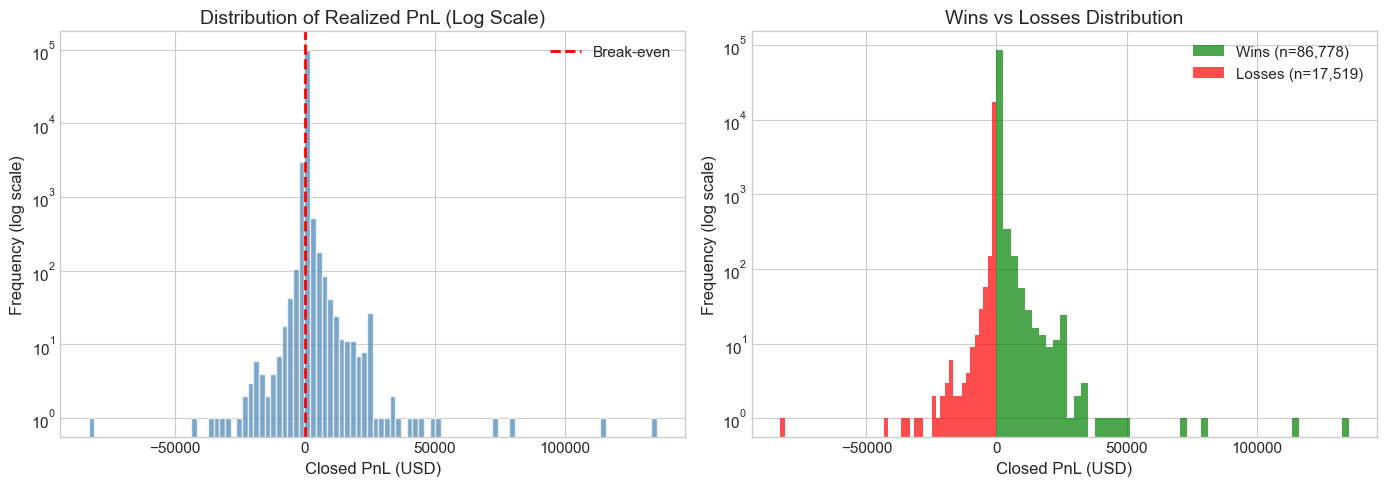

✓ Plot saved to: outputs/01_pnl_distribution.png


In [17]:
# Plot 1: PnL Distribution (Log Scale)
# Filter to closing trades with non-zero PnL
pnl_data = df[df['is_closed_trade'] == True]['Closed PnL']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with log scale on y-axis
ax1 = axes[0]
pnl_data.hist(bins=100, ax=ax1, color='steelblue', edgecolor='white', alpha=0.7)
ax1.set_yscale('log')
ax1.set_xlabel('Closed PnL (USD)')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_title('Distribution of Realized PnL (Log Scale)')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax1.legend()

# Separate positive and negative PnL
ax2 = axes[1]
wins = pnl_data[pnl_data > 0]
losses = pnl_data[pnl_data < 0]

ax2.hist(wins, bins=50, alpha=0.7, color='green', label=f'Wins (n={len(wins):,})')
ax2.hist(losses, bins=50, alpha=0.7, color='red', label=f'Losses (n={len(losses):,})')
ax2.set_yscale('log')
ax2.set_xlabel('Closed PnL (USD)')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Wins vs Losses Distribution')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/01_pnl_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/01_pnl_distribution.png")

**Interpretation:**
- The log scale reveals the heavy-tailed nature of trading PnL distributions
- Most trades cluster around small gains/losses, with rare but significant outliers
- The asymmetry between wins and losses indicates whether traders are cutting losses quickly or letting winners run
- A fat left tail (large losses) may indicate poor risk management or stop-loss discipline

## 4.2 Trade Size vs Leverage Proxy

**Behavioral Question:** Is there a relationship between trade size and the implied leverage? Do larger trades tend to use more aggressive position sizing?

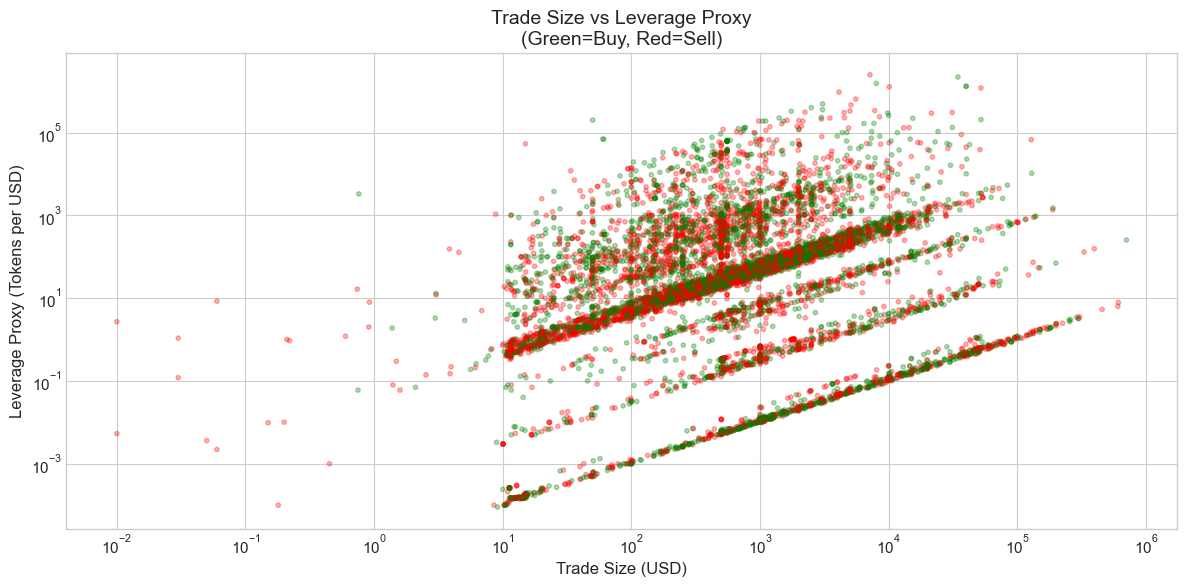

✓ Plot saved to: outputs/02_trade_size_vs_leverage.png


In [18]:
# Plot 2: Trade Size vs Leverage Proxy
# Leverage proxy = Size USD / Execution Price (higher ratio = more tokens for same USD)
# We'll use a sample for better visualization

# Calculate leverage proxy
df['leverage_proxy'] = df['Size USD'] / df['Execution Price']

# Sample for scatter plot (full dataset may be too dense)
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(df_sample['Size USD'], 
                      df_sample['leverage_proxy'],
                      alpha=0.3, 
                      c=df_sample['side'].map({'buy': 'green', 'sell': 'red'}),
                      s=10)

ax.set_xlabel('Trade Size (USD)')
ax.set_ylabel('Leverage Proxy (Tokens per USD)')
ax.set_title('Trade Size vs Leverage Proxy\n(Green=Buy, Red=Sell)')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(f'{output_dir}/02_trade_size_vs_leverage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/02_trade_size_vs_leverage.png")

**Interpretation:**
- The leverage proxy (tokens per USD) varies inversely with price - cheaper assets allow more tokens per dollar
- Different asset prices create natural clustering patterns
- Traders with consistently high leverage exposure across trade sizes may exhibit higher risk tolerance
- The color distribution (buy vs sell) can reveal directional bias at different size tiers

## 4.3 Trader Volume Concentration (Top 5%)

**Behavioral Question:** How concentrated is trading volume among participants? Do a small number of "whale" traders dominate the market?

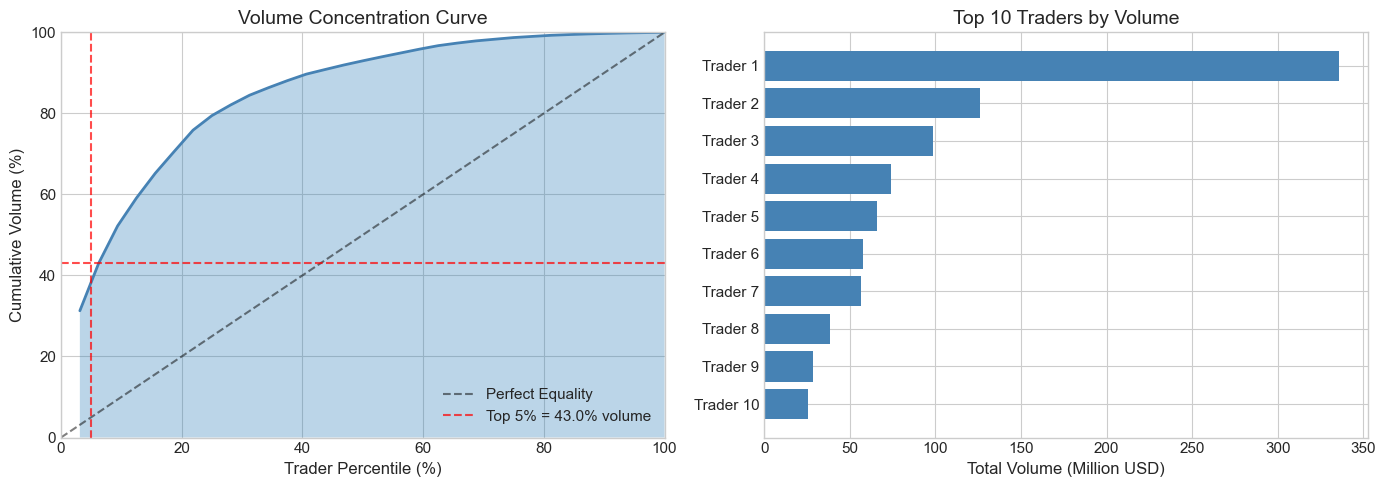

✓ Plot saved to: outputs/03_volume_concentration.png

Concentration Stats:
  Total traders: 32
  Top 5% traders control: 43.0% of volume
  Top 1% traders control: 31.3% of volume


In [19]:
# Plot 3: Trader Volume Concentration
# Aggregate total volume per trader
trader_volume = df.groupby('Account')['trade_notional'].sum().sort_values(ascending=False)

# Calculate cumulative percentage
trader_volume_df = pd.DataFrame({
    'trader_rank': range(1, len(trader_volume) + 1),
    'volume': trader_volume.values,
    'cumulative_volume': trader_volume.cumsum().values,
    'cumulative_pct': (trader_volume.cumsum() / trader_volume.sum() * 100).values
})

# Find top 5% threshold
top_5_pct_idx = int(len(trader_volume) * 0.05)
top_5_volume_pct = trader_volume_df.iloc[top_5_pct_idx]['cumulative_pct']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lorenz-like curve
ax1 = axes[0]
ax1.plot(trader_volume_df['trader_rank'] / len(trader_volume) * 100, 
         trader_volume_df['cumulative_pct'], 
         color='steelblue', linewidth=2)
ax1.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect Equality')
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.7, label=f'Top 5% = {top_5_volume_pct:.1f}% volume')
ax1.axhline(y=top_5_volume_pct, color='red', linestyle='--', alpha=0.7)
ax1.fill_between(trader_volume_df['trader_rank'] / len(trader_volume) * 100, 
                  trader_volume_df['cumulative_pct'], alpha=0.3)
ax1.set_xlabel('Trader Percentile (%)')
ax1.set_ylabel('Cumulative Volume (%)')
ax1.set_title('Volume Concentration Curve')
ax1.legend()
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# Top traders bar chart
ax2 = axes[1]
top_n = 10
top_traders = trader_volume.head(top_n)
bars = ax2.barh(range(top_n), top_traders.values / 1e6, color='steelblue')
ax2.set_yticks(range(top_n))
ax2.set_yticklabels([f'Trader {i+1}' for i in range(top_n)])
ax2.set_xlabel('Total Volume (Million USD)')
ax2.set_title(f'Top {top_n} Traders by Volume')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{output_dir}/03_volume_concentration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/03_volume_concentration.png")
print(f"\nConcentration Stats:")
print(f"  Total traders: {len(trader_volume):,}")
print(f"  Top 5% traders control: {top_5_volume_pct:.1f}% of volume")
print(f"  Top 1% traders control: {trader_volume_df.iloc[int(len(trader_volume)*0.01)]['cumulative_pct']:.1f}% of volume")

**Interpretation:**
- The Lorenz-like curve shows how far from "equal distribution" the trading volume is
- A curve bowing toward the lower-right indicates high concentration (few traders dominate)
- The top 5% metric is a standard benchmark for market concentration analysis
- High concentration may indicate:
  - Presence of institutional or algorithmic traders
  - Liquidity provision by market makers
  - Potential market manipulation risk if too concentrated

## 4.4 Long vs Short Trade Bias

**Behavioral Question:** Do traders exhibit a directional bias? Is there a preference for long (buy) or short (sell) positions in terms of volume or trade count?

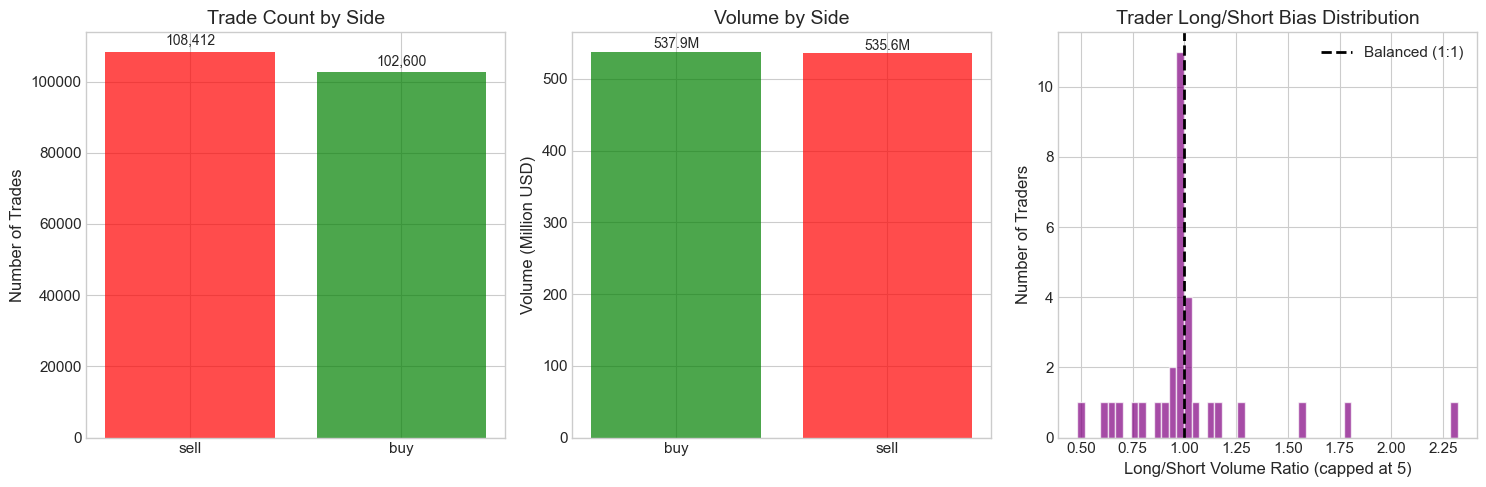

✓ Plot saved to: outputs/04_long_short_bias.png

Directional Bias Summary:
  Buy trades: 102,600 (48.6%)
  Sell trades: 108,412 (51.4%)
  Overall Long/Short Volume Ratio: 1.00


In [20]:
# Plot 4: Long vs Short Trade Bias
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 4a: Trade count by side
ax1 = axes[0]
side_counts = df['side'].value_counts()
colors = ['green' if s == 'buy' else 'red' for s in side_counts.index]
bars1 = ax1.bar(side_counts.index, side_counts.values, color=colors, alpha=0.7)
ax1.set_ylabel('Number of Trades')
ax1.set_title('Trade Count by Side')
for bar, val in zip(bars1, side_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{val:,}', ha='center', va='bottom', fontsize=10)

# 4b: Volume by side
ax2 = axes[1]
side_volume = df.groupby('side')['trade_notional'].sum() / 1e6
colors = ['green' if s == 'buy' else 'red' for s in side_volume.index]
bars2 = ax2.bar(side_volume.index, side_volume.values, color=colors, alpha=0.7)
ax2.set_ylabel('Volume (Million USD)')
ax2.set_title('Volume by Side')
for bar, val in zip(bars2, side_volume.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:,.1f}M', ha='center', va='bottom', fontsize=10)

# 4c: Long/Short ratio by trader
ax3 = axes[2]
trader_bias = df.groupby(['Account', 'side'])['trade_notional'].sum().unstack(fill_value=0)
trader_bias['long_short_ratio'] = np.where(
    trader_bias.get('sell', 0) > 0,
    trader_bias.get('buy', 0) / trader_bias.get('sell', 1),
    np.inf
)
# Replace inf with max finite value for visualization
trader_bias['long_short_ratio'] = trader_bias['long_short_ratio'].replace([np.inf], trader_bias['long_short_ratio'][trader_bias['long_short_ratio'] != np.inf].max())

# Histogram of long/short ratio
trader_bias['long_short_ratio'].clip(0, 5).hist(bins=50, ax=ax3, color='purple', alpha=0.7, edgecolor='white')
ax3.axvline(x=1, color='black', linestyle='--', linewidth=2, label='Balanced (1:1)')
ax3.set_xlabel('Long/Short Volume Ratio (capped at 5)')
ax3.set_ylabel('Number of Traders')
ax3.set_title('Trader Long/Short Bias Distribution')
ax3.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/04_long_short_bias.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/04_long_short_bias.png")

# Summary stats
buy_pct = side_counts.get('buy', 0) / side_counts.sum() * 100
print(f"\nDirectional Bias Summary:")
print(f"  Buy trades: {side_counts.get('buy', 0):,} ({buy_pct:.1f}%)")
print(f"  Sell trades: {side_counts.get('sell', 0):,} ({100-buy_pct:.1f}%)")
print(f"  Overall Long/Short Volume Ratio: {side_volume.get('buy', 0)/side_volume.get('sell', 1):.2f}")

**Interpretation:**
- A balanced market should have roughly equal buy and sell activity (matching buyers with sellers)
- Persistent directional bias may indicate:
  - Market sentiment (bullish = more longs)
  - Retail vs institutional behavior differences
  - Hedging activity patterns
- Individual trader bias distribution shows trading style:
  - Ratio > 1: Predominantly long traders (bullish bias)
  - Ratio < 1: Predominantly short traders (bearish bias)
  - Ratio ≈ 1: Balanced/market-neutral traders

---

# SECTION 5 — Outputs

Exporting cleaned and processed data for downstream analysis.

## 5.1 Save Cleaned Trade-Level Data

The cleaned trade-level dataset includes all engineered features and is ready for further analysis.

In [21]:
# Select columns to export for cleaned trade-level data
trade_export_cols = [
    'Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD',
    'side', 'direction', 'timestamp_utc', 'trade_date',
    'Start Position', 'Closed PnL', 'Fee', 'Trade ID', 'Order ID',
    'is_closed_trade', 'trade_notional', 'signed_size', 'fee_pct', 'is_win'
]

# Export cleaned trade data
trade_output_path = 'csv_files/trader_cleaned.csv'
df[trade_export_cols].to_csv(trade_output_path, index=False)

print(f"✓ Cleaned trade-level data saved to: {trade_output_path}")
print(f"  Shape: {df.shape[0]:,} rows × {len(trade_export_cols)} columns")

✓ Cleaned trade-level data saved to: csv_files/trader_cleaned.csv
  Shape: 211,012 rows × 19 columns


## 5.2 Save Daily Trader Metrics

The daily aggregated metrics provide a trader-day level view for behavioral pattern analysis.

In [22]:
# Export daily trader metrics
daily_output_path = 'csv_files/trader_daily_metrics.csv'
daily_metrics.to_csv(daily_output_path, index=False)

print(f"✓ Daily trader metrics saved to: {daily_output_path}")
print(f"  Shape: {daily_metrics.shape[0]:,} rows × {daily_metrics.shape[1]} columns")
print(f"\nColumns exported:")
print(daily_metrics.columns.tolist())

✓ Daily trader metrics saved to: csv_files/trader_daily_metrics.csv
  Shape: 2,343 rows × 14 columns

Columns exported:
['Account', 'trade_date', 'daily_pnl', 'daily_volume', 'avg_trade_size', 'num_trades', 'daily_fees', 'win_count', 'closing_trade_count', 'pnl_volatility', 'net_signed_size', 'buy_volume', 'win_rate', 'fee_pct_of_volume']


## 5.3 Output Summary

### Files Generated:

| File | Location | Description |
|------|----------|-------------|
| `trader_cleaned.csv` | `csv_files/` | Cleaned trade-level data with engineered features |
| `trader_daily_metrics.csv` | `csv_files/` | Daily aggregated trader metrics |
| `01_pnl_distribution.png` | `outputs/` | PnL distribution visualization |
| `02_trade_size_vs_leverage.png` | `outputs/` | Trade size vs leverage analysis |
| `03_volume_concentration.png` | `outputs/` | Trader volume concentration |
| `04_long_short_bias.png` | `outputs/` | Directional bias analysis |

---

## Next Steps (Notebook 2)

The cleaned data is now ready for:
1. Time-series analysis of trader behavior patterns
2. Correlation with external factors (Fear & Greed Index)
3. Trader segmentation and clustering
4. Predictive modeling for trader performance